In [4]:
import os
import sys
import itertools
import math
import tensorflow as tf
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon1

%matplotlib inline 

In [5]:
config = balloon1.BalloonConfig()
BALLOON_DIR = "C:\\Users\\gdelisle\\Downloads\\Mask_RCNN\\Mask_RCNN"

In [7]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = balloon1.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train",None)

#dataset.load_balloon(BALLOON_DIR)

# Must call before using the dataset
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    

Image Count: 74
Class Count: 3
  0. BG                                                
  1. mask                                              
  2. fail                                              


In [9]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [10]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [14]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [15]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [16]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
#weights_path = "C:\\Users\\gdelisle\\Downloads\\mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = "C:\\Users\\gdelisle\\Downloads\\Mask_RCNN\\Mask_RCNN\\logs\\balloon20180822T1511\\mask_rcnn_balloon_0030.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\gdelisle\Downloads\Mask_RCNN\Mask_RCNN\logs\balloon20180822T1511\mask_rcnn_balloon_0030.h5


{'id': 'fail11.png', 'source': 'region', 'path': 'C:\\Users\\gdelisle\\Downloads\\Mask_RCNN\\Mask_RCNN\\train\\fail11.png', 'width': 996, 'height': 519, 'polygons': [{'name': 'polygon', 'all_points_x': [395, 421, 456, 502, 516, 538, 543, 537, 522, 483, 473, 404, 395], 'all_points_y': [201, 197, 184, 175, 170, 176, 180, 165, 166, 165, 165, 185, 201]}, {'name': 'polygon', 'all_points_x': [394, 410, 483, 539, 538, 512, 483, 451, 414, 394], 'all_points_y': [310, 327, 344, 343, 332, 335, 329, 324, 315, 310]}, {'name': 'polygon', 'all_points_x': [342, 408, 484, 543, 605, 536, 470, 403, 342], 'all_points_y': [250, 328, 345, 342, 255, 164, 163, 185, 250]}], 'num_ids': [2, 2, 1]}
image ID: region.fail11.png (8) C:\Users\gdelisle\Downloads\Mask_RCNN\Mask_RCNN\train\fail11.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas  

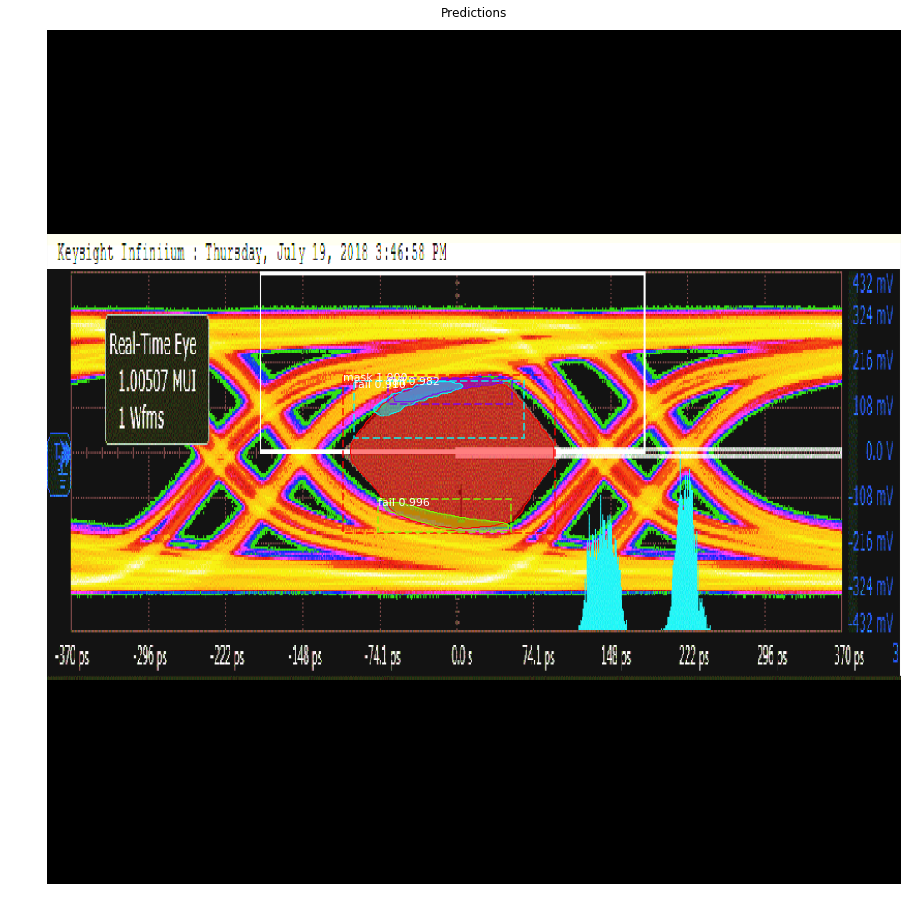

In [19]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

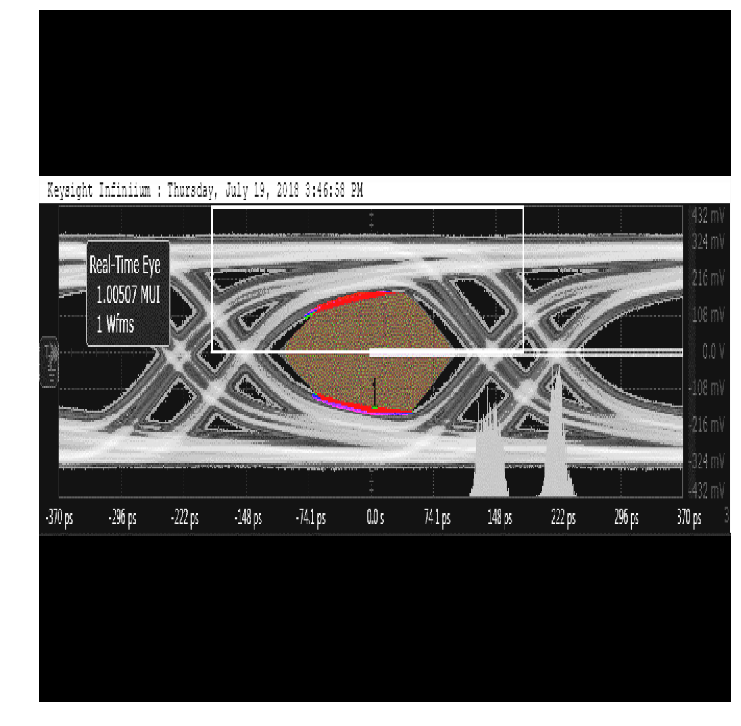

In [20]:
splash = balloon1.color_splash(image, r['masks'])
display_images([splash], cols=1)